In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt


parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=80, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension for GAN and BGAN")
parser.add_argument("--dcgan_img_size", type=int, default=32, help="size of each image dimension for DCGAN")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=938, help="interval between image sampling")
opt = parser.parse_args(args=[])
img_shape = (opt.channels, opt.img_size, opt.img_size)

print(opt)

device = "cuda" if torch.cuda.is_available() else "cpu"
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, dcgan_img_size=32, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_epochs=80, sample_interval=938)


# GAN

In [2]:
class gan_Generator(nn.Module):
    def __init__(self):
        super(gan_Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class gan_Discriminator(nn.Module):
    def __init__(self):
        super(gan_Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

# BGAN

In [3]:
class bgan_Generator(nn.Module):
    def __init__(self):
        super(bgan_Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class bgan_Discriminator(nn.Module):
    def __init__(self):
        super(bgan_Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


def boundary_seeking_loss(y_pred, y_true):
    """
    Boundary seeking loss.
    Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/
    """
    return 0.5 * torch.mean((torch.log(y_pred) - torch.log(1 - y_pred)) ** 2)

# DCGAN

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class dcgan_Generator(nn.Module):
    def __init__(self):
        super(dcgan_Generator, self).__init__()

        self.init_size = opt.dcgan_img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class dcgan_Discriminator(nn.Module):
    def __init__(self):
        super(dcgan_Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.dcgan_img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

# Training Function

In [5]:
def train_model(model_name):
    G_loss = []
    D_loss = []
    for epoch in range(1, opt.n_epochs+1):
        for i, (imgs, _) in enumerate(mnist_loader):
            # Generate ground truths
            valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # Train Generator
            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

            # Generate a batch of fake images
            gen_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            if model_name == "BGAN":
                g_loss = boundary_seeking_loss(discriminator(gen_imgs), valid)
            else:
                g_loss = criterion(discriminator(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            #  Train Discriminator
            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = criterion(discriminator(real_imgs), valid)
            fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            batches_done = epoch * len(mnist_loader) + i
            if batches_done % opt.sample_interval == 0:
                FID = compute_FID(real_imgs, gen_imgs)
                print("[Epoch %d/%d] [D loss: %.4f] [G loss: %.4f] [FID: %.4f]" % (epoch, opt.n_epochs, d_loss.item(), g_loss.item(), FID))
                if epoch % (opt.n_epochs/8) == 0:
                    fake_img_grid = make_grid(gen_imgs[:25], nrow=5, normalize=True) # img shape:(channel, img_size, img_size)
                    plt.imshow(fake_img_grid.permute(1, 2, 0).cpu().data.numpy()) # img shape:(img_size, img_size, channel)
                    plt.show()
        
        G_loss.append(g_loss.item())
        D_loss.append(d_loss.item())

    plot_training_loss(G_loss, D_loss, model_name)

# Plot Training Loss and Compute FID

In [6]:
def plot_training_loss(G_loss, D_loss, model_name):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_loss,label="G")
    plt.plot(D_loss,label="D")
    plt.title(model_name)
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

from torchvision.models import inception_v3
class InceptionNetwork(nn.Module):
    def __init__(self, transform_input=True):
        super().__init__()
        self.inception_network = inception_v3(pretrained=True)
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)
        self.transform_input = transform_input

    def output_hook(self, module, input, output):
        # N x 2048 x 8 x 8
        self.mixed_7c_output = output

    def forward(self, x):
        x = x * 2 -1 # Normalize to [-1, 1]

        self.inception_network(x)

        # Output: N x 2048 x 1 x 1 
        activations = self.mixed_7c_output
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1,1))
        activations = activations.view(x.shape[0], 2048)
        return activations


# get the embedding from InceptionNetwork
# and calculate the mean and standard deviation of the embeddings
def compute_act_mean_std(images, batch_size=1):
    num_images = images.shape[0]
    inception_network = InceptionNetwork().to(device)
    inception_network.eval()
    n_batches = int(np.ceil(num_images / batch_size))
    emb = np.zeros((num_images, 2048), dtype=np.float32)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)

        imgs = images[start_idx:end_idx].to(device)
        embedding = inception_network(imgs)
        embedding = embedding.detach().cpu().numpy()
        emb[start_idx:end_idx, :] = embedding

    mu = np.mean(emb, axis=0)
    sigma = np.cov(emb, rowvar=False)
    return mu, sigma


from scipy.linalg import sqrtm
def compute_FID(real_img, fake_img):
    inception_v3(pretrained=True).to(device)

    # change input image size to feed inception_network
    # batch_size*1*28*28 -> batch_size*3*299*299
    img_transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    real_img = img_transform(real_img)
    fake_img = img_transform(fake_img)
    
    # Get the mean and standard deviation of the embeddings
    mu_emb1, sigma_emb1 = compute_act_mean_std(real_img)
    mu_emb2, sigma_emb2 = compute_act_mean_std(fake_img)

    # Compute FID score
    mu1 = np.atleast_1d(mu_emb1)
    mu2 = np.atleast_1d(mu_emb2)
    sigma1 = np.atleast_2d(sigma_emb1)
    sigma2 = np.atleast_2d(sigma_emb2)

    diff = mu1 - mu2

    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    FID = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    
    return FID


# GAN Result

device:  cuda
[Epoch 1/80] [D loss: 0.7380] [G loss: 0.6982] [FID: 564.6179]
[Epoch 2/80] [D loss: 0.8353] [G loss: 0.2311] [FID: 193.5974]
[Epoch 3/80] [D loss: 0.3221] [G loss: 2.5989] [FID: 165.2320]
[Epoch 4/80] [D loss: 0.2303] [G loss: 1.1157] [FID: 154.2697]
[Epoch 5/80] [D loss: 0.1768] [G loss: 1.8564] [FID: 127.5759]
[Epoch 6/80] [D loss: 0.2874] [G loss: 1.4521] [FID: 134.0168]
[Epoch 7/80] [D loss: 0.2924] [G loss: 1.1863] [FID: 108.4172]
[Epoch 8/80] [D loss: 0.2165] [G loss: 3.3742] [FID: 109.8904]
[Epoch 9/80] [D loss: 0.2495] [G loss: 4.9414] [FID: 90.1882]
[Epoch 10/80] [D loss: 0.1541] [G loss: 2.9342] [FID: 122.3403]


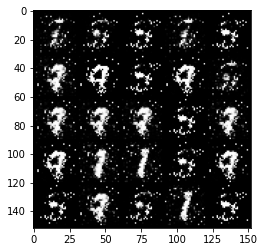

[Epoch 11/80] [D loss: 0.3524] [G loss: 2.9250] [FID: 103.1298]
[Epoch 12/80] [D loss: 0.3445] [G loss: 3.8061] [FID: 120.6172]
[Epoch 13/80] [D loss: 0.2161] [G loss: 2.6531] [FID: 82.4977]
[Epoch 14/80] [D loss: 0.2132] [G loss: 2.3452] [FID: 123.1500]
[Epoch 15/80] [D loss: 0.1636] [G loss: 2.3708] [FID: 99.9646]
[Epoch 16/80] [D loss: 0.4177] [G loss: 0.9244] [FID: 69.2911]
[Epoch 17/80] [D loss: 0.2240] [G loss: 2.2917] [FID: 54.9337]
[Epoch 18/80] [D loss: 0.4982] [G loss: 4.8705] [FID: 87.4514]
[Epoch 19/80] [D loss: 0.6391] [G loss: 0.6031] [FID: 49.8204]
[Epoch 20/80] [D loss: 0.2611] [G loss: 1.7128] [FID: 59.5189]


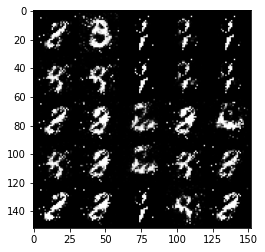

[Epoch 21/80] [D loss: 0.1809] [G loss: 2.0158] [FID: 55.9665]
[Epoch 22/80] [D loss: 0.2549] [G loss: 1.7424] [FID: 49.1691]
[Epoch 23/80] [D loss: 0.2812] [G loss: 1.5331] [FID: 65.2689]
[Epoch 24/80] [D loss: 0.2749] [G loss: 3.2524] [FID: 71.5166]
[Epoch 25/80] [D loss: 0.1969] [G loss: 3.2608] [FID: 53.5885]
[Epoch 26/80] [D loss: 0.2184] [G loss: 2.4088] [FID: 64.0709]
[Epoch 27/80] [D loss: 0.2535] [G loss: 3.2160] [FID: 70.5654]
[Epoch 28/80] [D loss: 0.2456] [G loss: 2.6914] [FID: 55.5942]
[Epoch 29/80] [D loss: 0.3537] [G loss: 4.2244] [FID: 50.1138]
[Epoch 30/80] [D loss: 0.1997] [G loss: 2.2579] [FID: 50.7284]


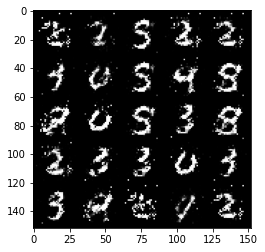

[Epoch 31/80] [D loss: 0.2110] [G loss: 3.0642] [FID: 49.1300]
[Epoch 32/80] [D loss: 0.5141] [G loss: 1.1015] [FID: 61.5472]
[Epoch 33/80] [D loss: 0.4194] [G loss: 4.1782] [FID: 67.3142]
[Epoch 34/80] [D loss: 0.1579] [G loss: 1.7481] [FID: 62.0183]
[Epoch 35/80] [D loss: 0.1633] [G loss: 3.1948] [FID: 57.4600]
[Epoch 36/80] [D loss: 0.2681] [G loss: 3.0943] [FID: 50.2073]
[Epoch 37/80] [D loss: 0.3125] [G loss: 2.3163] [FID: 43.5176]
[Epoch 38/80] [D loss: 0.2144] [G loss: 1.9960] [FID: 63.2972]
[Epoch 39/80] [D loss: 0.2534] [G loss: 1.9087] [FID: 57.7690]
[Epoch 40/80] [D loss: 0.3274] [G loss: 4.0412] [FID: 66.4380]


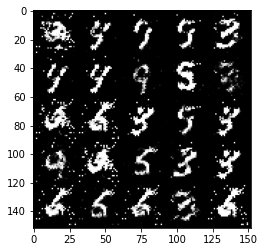

[Epoch 41/80] [D loss: 0.1505] [G loss: 2.3463] [FID: 54.7002]
[Epoch 42/80] [D loss: 0.2281] [G loss: 2.3633] [FID: 48.8029]
[Epoch 43/80] [D loss: 0.2505] [G loss: 3.7897] [FID: 51.8423]
[Epoch 44/80] [D loss: 0.2057] [G loss: 3.7376] [FID: 48.9289]
[Epoch 45/80] [D loss: 0.2621] [G loss: 2.2160] [FID: 49.6439]
[Epoch 46/80] [D loss: 0.2608] [G loss: 2.5967] [FID: 40.7440]
[Epoch 47/80] [D loss: 0.2453] [G loss: 3.4019] [FID: 40.4306]
[Epoch 48/80] [D loss: 0.1824] [G loss: 2.3020] [FID: 77.6972]
[Epoch 49/80] [D loss: 0.2440] [G loss: 2.2662] [FID: 44.5646]
[Epoch 50/80] [D loss: 0.4961] [G loss: 0.7392] [FID: 50.6484]


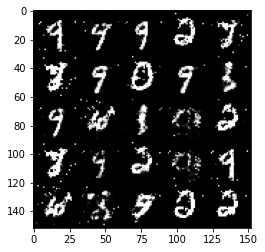

[Epoch 51/80] [D loss: 0.4028] [G loss: 3.6994] [FID: 39.4120]
[Epoch 52/80] [D loss: 0.2375] [G loss: 2.7076] [FID: 35.7366]
[Epoch 53/80] [D loss: 0.1859] [G loss: 2.0247] [FID: 44.5628]
[Epoch 54/80] [D loss: 0.2687] [G loss: 3.0783] [FID: 35.1359]
[Epoch 55/80] [D loss: 0.3767] [G loss: 1.9923] [FID: 35.0286]
[Epoch 56/80] [D loss: 0.1706] [G loss: 2.1994] [FID: 47.0990]
[Epoch 57/80] [D loss: 0.1980] [G loss: 2.7470] [FID: 54.4121]
[Epoch 58/80] [D loss: 0.2660] [G loss: 4.0394] [FID: 38.9628]
[Epoch 59/80] [D loss: 0.1777] [G loss: 3.3971] [FID: 42.3457]
[Epoch 60/80] [D loss: 0.4493] [G loss: 4.7209] [FID: 36.5880]


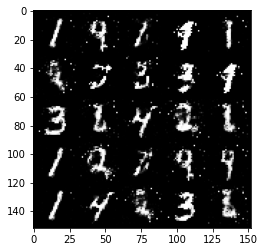

[Epoch 61/80] [D loss: 0.2769] [G loss: 2.8798] [FID: 31.4586]
[Epoch 62/80] [D loss: 0.1514] [G loss: 2.2980] [FID: 39.6576]
[Epoch 63/80] [D loss: 0.3714] [G loss: 4.5163] [FID: 31.6136]
[Epoch 64/80] [D loss: 0.3789] [G loss: 3.4777] [FID: 29.0122]
[Epoch 65/80] [D loss: 0.2317] [G loss: 2.0811] [FID: 40.9155]
[Epoch 66/80] [D loss: 0.2948] [G loss: 3.1909] [FID: 44.9338]
[Epoch 67/80] [D loss: 0.2202] [G loss: 2.9187] [FID: 38.8273]
[Epoch 68/80] [D loss: 0.2151] [G loss: 1.7804] [FID: 37.1472]
[Epoch 69/80] [D loss: 0.3473] [G loss: 3.3644] [FID: 32.1531]
[Epoch 70/80] [D loss: 0.2366] [G loss: 1.8178] [FID: 36.4436]


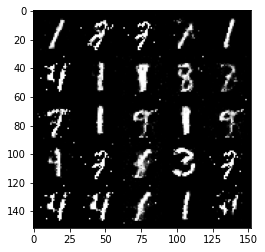

[Epoch 71/80] [D loss: 0.1690] [G loss: 2.5169] [FID: 27.7552]
[Epoch 72/80] [D loss: 0.3412] [G loss: 1.3591] [FID: 32.4070]
[Epoch 73/80] [D loss: 0.3187] [G loss: 3.9681] [FID: 38.4370]
[Epoch 74/80] [D loss: 0.4931] [G loss: 1.0202] [FID: 29.1241]
[Epoch 75/80] [D loss: 0.1521] [G loss: 2.1895] [FID: 32.0622]
[Epoch 76/80] [D loss: 0.3583] [G loss: 1.6455] [FID: 31.3355]
[Epoch 77/80] [D loss: 0.1727] [G loss: 3.2386] [FID: 28.3291]
[Epoch 78/80] [D loss: 0.2556] [G loss: 2.5851] [FID: 33.8337]
[Epoch 79/80] [D loss: 0.1977] [G loss: 2.1523] [FID: 35.2493]
[Epoch 80/80] [D loss: 0.1851] [G loss: 2.2284] [FID: 41.3279]


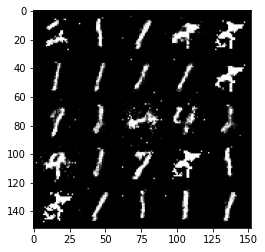

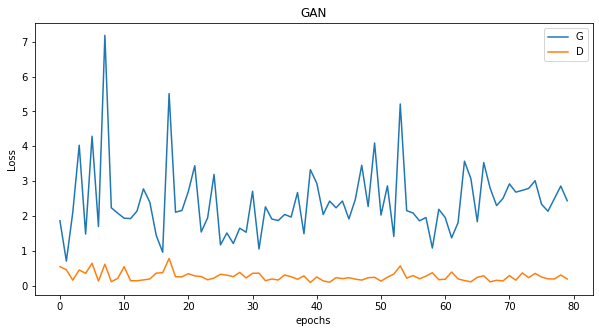

In [9]:
# Data loader
os.makedirs("data_mnist", exist_ok=True)
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data_mnist",
                   train=True,
                   download=True,
                   transform=transforms.Compose([transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = gan_Generator().to(device)
discriminator = gan_Discriminator().to(device)

print("device: ", device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

train_model(model_name = "GAN")

# BGAN Result

device:  cuda
[Epoch 1/80] [D loss: 0.6831] [G loss: 0.0030] [FID: 562.1539]
[Epoch 2/80] [D loss: 0.3902] [G loss: 0.3714] [FID: 149.6488]
[Epoch 3/80] [D loss: 0.5568] [G loss: 0.2382] [FID: 106.5213]
[Epoch 4/80] [D loss: 0.1839] [G loss: 1.8896] [FID: 124.2378]
[Epoch 5/80] [D loss: 0.3348] [G loss: 0.4705] [FID: 126.5461]
[Epoch 6/80] [D loss: 0.2520] [G loss: 0.7722] [FID: 80.3494]
[Epoch 7/80] [D loss: 0.2825] [G loss: 0.4320] [FID: 100.3835]
[Epoch 8/80] [D loss: 0.3774] [G loss: 0.3500] [FID: 67.6007]
[Epoch 9/80] [D loss: 0.3310] [G loss: 8.7353] [FID: 67.3917]
[Epoch 10/80] [D loss: 0.1950] [G loss: 1.2081] [FID: 60.0018]


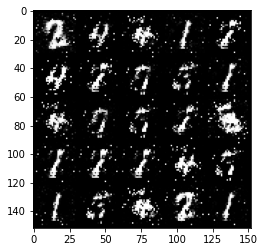

[Epoch 11/80] [D loss: 0.3989] [G loss: 6.8057] [FID: 73.8992]
[Epoch 12/80] [D loss: 0.2670] [G loss: 2.9082] [FID: 55.8362]
[Epoch 13/80] [D loss: 0.2981] [G loss: 0.5074] [FID: 52.2899]
[Epoch 14/80] [D loss: 0.4271] [G loss: 6.7683] [FID: 58.6246]
[Epoch 15/80] [D loss: 0.1633] [G loss: 1.2273] [FID: 57.6683]
[Epoch 16/80] [D loss: 0.1808] [G loss: 2.7653] [FID: 50.8575]
[Epoch 17/80] [D loss: 0.4347] [G loss: 9.5100] [FID: 63.3408]
[Epoch 18/80] [D loss: 0.2155] [G loss: 3.2017] [FID: 43.1499]
[Epoch 19/80] [D loss: 0.3567] [G loss: 0.4571] [FID: 47.0355]
[Epoch 20/80] [D loss: 0.2332] [G loss: 3.3783] [FID: 42.9216]


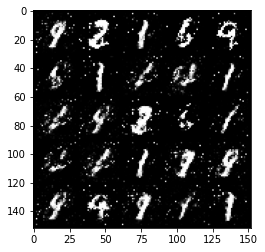

[Epoch 21/80] [D loss: 0.3114] [G loss: 6.8423] [FID: 54.9705]
[Epoch 22/80] [D loss: 0.6210] [G loss: 0.7041] [FID: 43.0605]
[Epoch 23/80] [D loss: 0.2676] [G loss: 2.3936] [FID: 50.0123]
[Epoch 24/80] [D loss: 0.3358] [G loss: 3.4440] [FID: 46.2252]
[Epoch 25/80] [D loss: 0.3050] [G loss: 1.4762] [FID: 38.7924]
[Epoch 26/80] [D loss: 0.4663] [G loss: 0.4456] [FID: 37.7331]
[Epoch 27/80] [D loss: 0.2144] [G loss: 1.4153] [FID: 47.3040]
[Epoch 28/80] [D loss: 0.2855] [G loss: 1.9740] [FID: 41.4822]
[Epoch 29/80] [D loss: 0.2815] [G loss: 2.7432] [FID: 45.4031]
[Epoch 30/80] [D loss: 0.4639] [G loss: 8.6695] [FID: 36.0494]


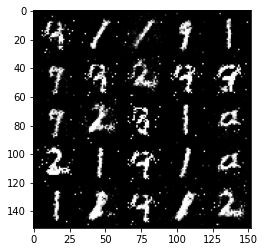

[Epoch 31/80] [D loss: 0.2027] [G loss: 2.2025] [FID: 31.7554]
[Epoch 32/80] [D loss: 0.2257] [G loss: 3.1769] [FID: 39.2365]
[Epoch 33/80] [D loss: 0.2706] [G loss: 1.1955] [FID: 31.4668]
[Epoch 34/80] [D loss: 0.2601] [G loss: 1.0721] [FID: 38.8895]
[Epoch 35/80] [D loss: 0.2574] [G loss: 2.2361] [FID: 43.7877]
[Epoch 36/80] [D loss: 0.3521] [G loss: 8.3982] [FID: 43.0043]
[Epoch 37/80] [D loss: 0.2211] [G loss: 4.3005] [FID: 42.3993]
[Epoch 38/80] [D loss: 0.1688] [G loss: 1.5359] [FID: 48.8855]
[Epoch 39/80] [D loss: 0.3261] [G loss: 6.2083] [FID: 51.2577]
[Epoch 40/80] [D loss: 0.4066] [G loss: 7.8996] [FID: 45.2988]


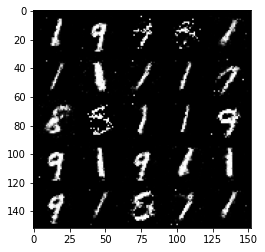

[Epoch 41/80] [D loss: 0.1663] [G loss: 2.8025] [FID: 34.3229]
[Epoch 42/80] [D loss: 0.1679] [G loss: 1.9121] [FID: 43.2779]
[Epoch 43/80] [D loss: 0.1765] [G loss: 2.7636] [FID: 36.7501]
[Epoch 44/80] [D loss: 0.3606] [G loss: 0.4941] [FID: 42.1651]
[Epoch 45/80] [D loss: 0.1949] [G loss: 1.8302] [FID: 52.8987]
[Epoch 46/80] [D loss: 0.2761] [G loss: 0.5076] [FID: 40.4526]
[Epoch 47/80] [D loss: 0.1781] [G loss: 2.6407] [FID: 42.7276]
[Epoch 48/80] [D loss: 0.2141] [G loss: 3.2503] [FID: 46.3780]
[Epoch 49/80] [D loss: 0.1319] [G loss: 6.6580] [FID: 50.1662]
[Epoch 50/80] [D loss: 0.2616] [G loss: 1.3559] [FID: 39.7752]


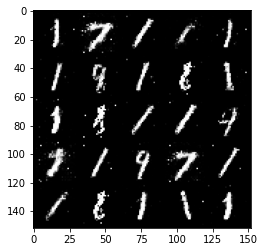

[Epoch 51/80] [D loss: 0.2446] [G loss: 5.1391] [FID: 49.0044]
[Epoch 52/80] [D loss: 0.3643] [G loss: 1.1683] [FID: 41.9170]
[Epoch 53/80] [D loss: 0.2029] [G loss: 2.4435] [FID: 40.3347]
[Epoch 54/80] [D loss: 0.2802] [G loss: 1.9677] [FID: 43.1665]
[Epoch 55/80] [D loss: 0.1616] [G loss: 3.0791] [FID: 42.8692]
[Epoch 56/80] [D loss: 0.1593] [G loss: 5.1444] [FID: 65.5824]
[Epoch 57/80] [D loss: 0.3394] [G loss: 4.6437] [FID: 39.2118]
[Epoch 58/80] [D loss: 0.2319] [G loss: 2.3910] [FID: 46.3412]
[Epoch 59/80] [D loss: 0.2397] [G loss: 1.0102] [FID: 53.2929]
[Epoch 60/80] [D loss: 0.2252] [G loss: 2.2132] [FID: 50.3715]


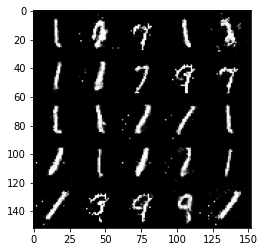

[Epoch 61/80] [D loss: 0.2472] [G loss: 2.9548] [FID: 43.9187]
[Epoch 62/80] [D loss: 0.2583] [G loss: 4.0344] [FID: 52.5945]
[Epoch 63/80] [D loss: 0.2461] [G loss: 1.3481] [FID: 54.8869]
[Epoch 64/80] [D loss: 0.2282] [G loss: 1.6225] [FID: 55.9572]
[Epoch 65/80] [D loss: 0.2071] [G loss: 1.1682] [FID: 56.3245]
[Epoch 66/80] [D loss: 0.1389] [G loss: 3.3353] [FID: 60.7097]
[Epoch 67/80] [D loss: 0.2637] [G loss: 1.9853] [FID: 53.1632]
[Epoch 68/80] [D loss: 0.1117] [G loss: 3.2698] [FID: 51.9716]
[Epoch 69/80] [D loss: 0.2098] [G loss: 1.3645] [FID: 55.4883]
[Epoch 70/80] [D loss: 0.3560] [G loss: 0.8680] [FID: 44.1310]


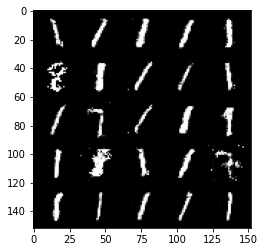

[Epoch 71/80] [D loss: 0.1423] [G loss: 2.8489] [FID: 57.7331]
[Epoch 72/80] [D loss: 0.2816] [G loss: 2.6282] [FID: 48.4031]
[Epoch 73/80] [D loss: 0.2607] [G loss: 3.7019] [FID: 59.3902]
[Epoch 74/80] [D loss: 0.1814] [G loss: 4.4827] [FID: 59.6935]
[Epoch 75/80] [D loss: 0.1685] [G loss: 2.0690] [FID: 64.2186]
[Epoch 76/80] [D loss: 0.2549] [G loss: 3.6976] [FID: 57.0927]
[Epoch 77/80] [D loss: 0.1274] [G loss: 3.6040] [FID: 63.1138]
[Epoch 78/80] [D loss: 0.2212] [G loss: 2.6216] [FID: 52.9519]
[Epoch 79/80] [D loss: 0.1706] [G loss: 2.0968] [FID: 64.7230]
[Epoch 80/80] [D loss: 0.2288] [G loss: 1.5670] [FID: 55.7431]


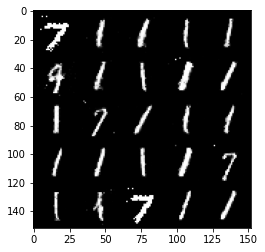

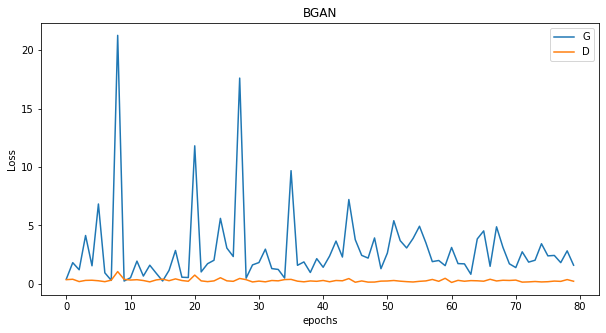

In [10]:
# Data loader
os.makedirs("data_mnist", exist_ok=True)
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data_mnist",
                   train=True,
                   download=True,
                   transform=transforms.Compose([transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = bgan_Generator().to(device)
discriminator = bgan_Discriminator().to(device)

print("device: ", device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

train_model(model_name = "BGAN")

# DCGAN Result

device:  cuda
[Epoch 1/80] [D loss: 0.6933] [G loss: 0.7089] [FID: 597.5277]
[Epoch 2/80] [D loss: 0.6908] [G loss: 0.7046] [FID: 31.4625]
[Epoch 3/80] [D loss: 0.6618] [G loss: 0.7425] [FID: 22.4012]
[Epoch 4/80] [D loss: 0.7227] [G loss: 0.8534] [FID: 22.9879]
[Epoch 5/80] [D loss: 0.5812] [G loss: 0.8870] [FID: 19.2131]
[Epoch 6/80] [D loss: 0.6120] [G loss: 0.9483] [FID: 17.5269]
[Epoch 7/80] [D loss: 0.5328] [G loss: 0.8947] [FID: 19.0314]
[Epoch 8/80] [D loss: 0.5017] [G loss: 1.0325] [FID: 22.2919]
[Epoch 9/80] [D loss: 0.6504] [G loss: 1.2516] [FID: 23.3308]
[Epoch 10/80] [D loss: 0.4384] [G loss: 0.7313] [FID: 19.9136]


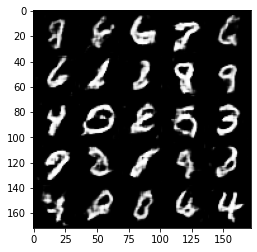

[Epoch 11/80] [D loss: 0.6062] [G loss: 0.6062] [FID: 18.0191]
[Epoch 12/80] [D loss: 0.5106] [G loss: 0.9943] [FID: 18.0063]
[Epoch 13/80] [D loss: 0.4321] [G loss: 0.9550] [FID: 20.3316]
[Epoch 14/80] [D loss: 0.5731] [G loss: 1.4069] [FID: 18.6071]
[Epoch 15/80] [D loss: 0.4943] [G loss: 0.7580] [FID: 16.6641]
[Epoch 16/80] [D loss: 0.6722] [G loss: 0.9433] [FID: 17.6329]
[Epoch 17/80] [D loss: 0.5325] [G loss: 0.4810] [FID: 18.6730]
[Epoch 18/80] [D loss: 0.6805] [G loss: 1.6453] [FID: 19.6586]
[Epoch 19/80] [D loss: 0.4538] [G loss: 0.6574] [FID: 18.5828]
[Epoch 20/80] [D loss: 0.4267] [G loss: 0.6839] [FID: 18.2573]


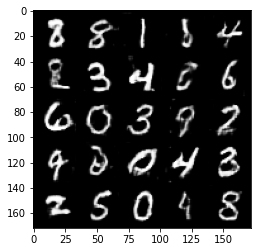

[Epoch 21/80] [D loss: 0.8908] [G loss: 0.4277] [FID: 17.1014]
[Epoch 22/80] [D loss: 0.5696] [G loss: 0.5966] [FID: 19.2574]
[Epoch 23/80] [D loss: 0.4877] [G loss: 0.3915] [FID: 18.6254]
[Epoch 24/80] [D loss: 0.4785] [G loss: 1.0989] [FID: 14.8694]
[Epoch 25/80] [D loss: 0.7490] [G loss: 1.1940] [FID: 17.4723]
[Epoch 26/80] [D loss: 0.5227] [G loss: 0.7100] [FID: 19.7731]
[Epoch 27/80] [D loss: 0.5308] [G loss: 0.5572] [FID: 20.3690]
[Epoch 28/80] [D loss: 0.4418] [G loss: 0.9810] [FID: 19.7421]
[Epoch 29/80] [D loss: 0.7373] [G loss: 0.7097] [FID: 18.6041]
[Epoch 30/80] [D loss: 0.5885] [G loss: 1.8650] [FID: 18.4666]


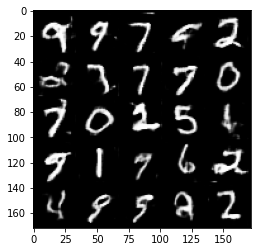

[Epoch 31/80] [D loss: 0.6231] [G loss: 0.7288] [FID: 18.3524]
[Epoch 32/80] [D loss: 0.7374] [G loss: 0.7426] [FID: 17.1532]
[Epoch 33/80] [D loss: 0.5239] [G loss: 1.0456] [FID: 19.2989]
[Epoch 34/80] [D loss: 0.4762] [G loss: 1.2890] [FID: 18.6050]
[Epoch 35/80] [D loss: 0.7415] [G loss: 0.9936] [FID: 17.9385]
[Epoch 36/80] [D loss: 0.5293] [G loss: 1.1655] [FID: 16.4972]
[Epoch 37/80] [D loss: 0.4937] [G loss: 0.8479] [FID: 16.2610]
[Epoch 38/80] [D loss: 0.2528] [G loss: 0.6714] [FID: 18.9307]
[Epoch 39/80] [D loss: 0.3812] [G loss: 0.5358] [FID: 16.7879]
[Epoch 40/80] [D loss: 0.3958] [G loss: 1.0172] [FID: 17.2014]


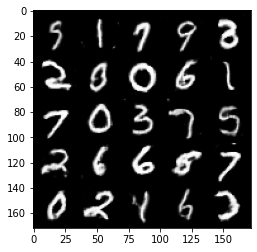

[Epoch 41/80] [D loss: 0.4636] [G loss: 2.2227] [FID: 17.4064]
[Epoch 42/80] [D loss: 0.4912] [G loss: 0.8027] [FID: 17.6893]
[Epoch 43/80] [D loss: 0.5801] [G loss: 0.8363] [FID: 17.7245]
[Epoch 44/80] [D loss: 0.3427] [G loss: 0.7523] [FID: 17.2535]
[Epoch 45/80] [D loss: 0.5268] [G loss: 2.6133] [FID: 18.2083]
[Epoch 46/80] [D loss: 0.5102] [G loss: 1.2089] [FID: 16.6584]
[Epoch 47/80] [D loss: 0.5436] [G loss: 0.7943] [FID: 19.7650]
[Epoch 48/80] [D loss: 0.4980] [G loss: 0.9265] [FID: 17.4764]
[Epoch 49/80] [D loss: 0.6356] [G loss: 1.7252] [FID: 17.2224]
[Epoch 50/80] [D loss: 0.2978] [G loss: 0.8564] [FID: 18.2746]


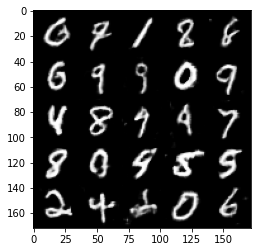

[Epoch 51/80] [D loss: 0.9135] [G loss: 1.1806] [FID: 18.8387]
[Epoch 52/80] [D loss: 0.4582] [G loss: 1.0616] [FID: 16.2192]
[Epoch 53/80] [D loss: 0.4780] [G loss: 0.5997] [FID: 16.0050]
[Epoch 54/80] [D loss: 0.4120] [G loss: 1.2591] [FID: 17.1715]
[Epoch 55/80] [D loss: 0.6124] [G loss: 1.2949] [FID: 17.3901]
[Epoch 56/80] [D loss: 0.6506] [G loss: 2.4731] [FID: 16.2166]
[Epoch 57/80] [D loss: 0.5493] [G loss: 1.5188] [FID: 16.5143]
[Epoch 58/80] [D loss: 0.1782] [G loss: 0.8882] [FID: 17.5073]
[Epoch 59/80] [D loss: 0.7853] [G loss: 3.4711] [FID: 15.3626]
[Epoch 60/80] [D loss: 0.3555] [G loss: 2.6931] [FID: 15.1523]


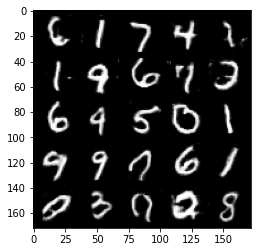

[Epoch 61/80] [D loss: 0.3930] [G loss: 1.4755] [FID: 17.6812]
[Epoch 62/80] [D loss: 0.5419] [G loss: 0.9547] [FID: 16.2831]
[Epoch 63/80] [D loss: 0.4246] [G loss: 2.4446] [FID: 16.7354]
[Epoch 64/80] [D loss: 0.1854] [G loss: 4.7877] [FID: 17.5830]
[Epoch 65/80] [D loss: 0.6518] [G loss: 0.9949] [FID: 17.6556]
[Epoch 66/80] [D loss: 0.3945] [G loss: 0.7687] [FID: 16.5061]
[Epoch 67/80] [D loss: 0.4500] [G loss: 2.0003] [FID: 19.5969]
[Epoch 68/80] [D loss: 0.3395] [G loss: 2.9109] [FID: 16.4074]
[Epoch 69/80] [D loss: 0.5413] [G loss: 2.5161] [FID: 16.8761]
[Epoch 70/80] [D loss: 0.1668] [G loss: 0.7909] [FID: 16.5619]


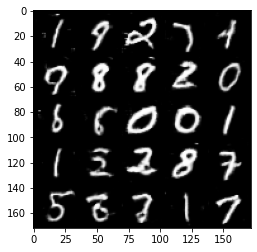

[Epoch 71/80] [D loss: 0.1925] [G loss: 1.8781] [FID: 15.9631]
[Epoch 72/80] [D loss: 0.3265] [G loss: 1.1660] [FID: 17.2273]
[Epoch 73/80] [D loss: 0.0977] [G loss: 2.7502] [FID: 15.2581]
[Epoch 74/80] [D loss: 0.0762] [G loss: 0.7950] [FID: 16.6590]
[Epoch 75/80] [D loss: 0.2264] [G loss: 6.4036] [FID: 16.3431]
[Epoch 76/80] [D loss: 0.1597] [G loss: 2.0323] [FID: 16.6499]
[Epoch 77/80] [D loss: 0.2788] [G loss: 0.7140] [FID: 17.6029]
[Epoch 78/80] [D loss: 0.0985] [G loss: 1.6148] [FID: 16.3540]
[Epoch 79/80] [D loss: 0.1611] [G loss: 3.8908] [FID: 16.9472]
[Epoch 80/80] [D loss: 0.0644] [G loss: 4.6736] [FID: 17.7221]


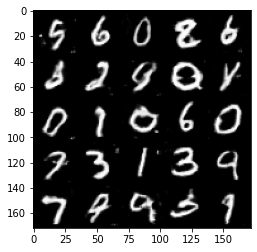

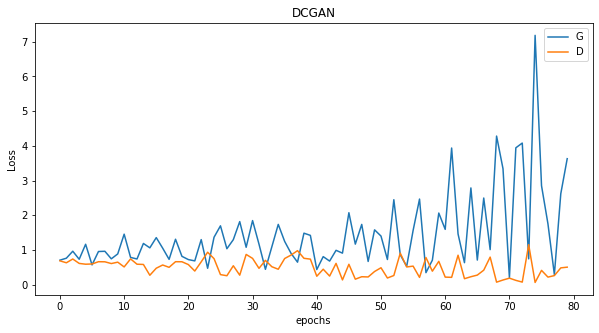

In [8]:
# Data loader (change input size from 28*28 to 32*32)
os.makedirs("data_mnist", exist_ok=True)
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data_mnist",
                   train=True,
                   download=True,
                   transform=transforms.Compose([transforms.Resize(opt.dcgan_img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = dcgan_Generator().to(device)
discriminator = dcgan_Discriminator().to(device)

print("device: ", device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

train_model(model_name = "DCGAN")

# Discussion

我實作了 GAN、BGAN、DCGAN 三種不同的 GAN，很明顯 DCGAN 產生出的 MNIST 圖片最正常，FID score也是最低的（FID越低越好）。

由於想比較三種不同 GAN 在同一組參數下的表現，所以 GAN 訓練得不太好，如果 GAN 再多跑幾個 epoch 應該會長的比較正常。

不過 DCGAN 的 generator loss 越跑越震盪，我也是看不太懂，畢竟它的 FID score 相較另外兩種 GAN 還蠻穩定的（數值波動幅度）。